This file test the model ability on prediction for unseen output (unseen (lat,lon)). 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import torch 
import matplotlib.pyplot as plt

In [2]:
# Specify model and likelihood
import yaml

with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/spatiotemp_lvmogp_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
data_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/climate_data/tas_Amon_HadGEM2-A_amip_r1i1p1_197809-200811.nc'
dataset = xr.open_dataset(data_path, decode_times=False)
print(dataset)

tas = dataset['tas']
lat = dataset['lat']
lon = dataset['lon']

tas_torch_ = torch.tensor(tas.values)
lat_torch_ = torch.tensor(lat.values)
lon_torch_ = torch.tensor(lon.values)

# Subsampling ... these are the location used in training
tas_torch = tas_torch_[:, ::5, ::5] #:60 for time, ::5 for lat and lon
lat_torch = lat_torch_[::5]
lon_torch = lon_torch_[::5]

n_lon = lon_torch.shape[0]
n_lat = lat_torch.shape[0]
# Three dims: time, latitude, longitude

lon_lat_tensor_ = torch.zeros(n_lon, n_lat, 2)
for i in range(n_lon):
    for j in range(n_lat):
        lon_lat_tensor_[i, j, :] = torch.tensor([lon_torch[i].item(), lat_torch[j].item()])

lon_lat_tensor_reshape = lon_lat_tensor_.reshape(-1, 2)
lon_lat_means, lon_lat_stds = lon_lat_tensor_reshape.mean(dim=0), lon_lat_tensor_reshape.std(dim=0, unbiased=False)

# Identify all new lats and lons

lat_mask = torch.isin(lat_torch_, lat_torch, invert=True)
lon_mask = torch.isin(lon_torch_, lon_torch, invert=True)

new_lat_torch = lat_torch_[lat_mask]
new_lon_torch = lon_torch_[lon_mask]

assert new_lat_torch.shape[0] + n_lat == lat_torch_.shape[0]
assert new_lon_torch.shape[0] + n_lon == lon_torch_.shape[0]


# lon_torch, lat_torch, new_lon_torch, new_lat_torch


<xarray.Dataset>
Dimensions:    (time: 363, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) float64 15.0 45.0 75.0 ... 1.082e+04 1.084e+04 1.088e+04
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/28)
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    institute_id:           MOHC
    experiment_id:          amip
    source:                 HadGEM2-A (2009) atmosphere: HadGAM2 (N96L38);  l...
    model_id:               HadGEM2-A
    forcing:                GHG, SA, Oz, LU, Sl, Vl, BC, OC, (GHG = CO2, N2O,...
    ...                     ...
    table_id:               Table A

In [4]:
def pick_new_spatio_temp_data_and_loc(lon_idx, lat_idx, curr_lon_torch, curr_lat_torch):
    '''
    Arg:
        lon_idx, lat_idx: idx to pick within current tensors.
        curr_lon_torch, curr_lat_torch: the tensors we are working on.

    Return the normalized target data (tas) and normalized location tensor for selected output
    given their idx.

    Following variables are defined outside this function:

    lon_torch_; all lon
    lat_torch_; all lat
    tas_torch_; all timeseries for all lat and lon
    lon_torch; subsampled lon (for training lvmogp)
    lat_torch; subsampled lat (for training lvmogp)
    '''
    assert curr_lon_torch.shape[0] > lon_idx
    assert curr_lat_torch.shape[0] > lat_idx

    picked_lon = curr_lon_torch[lon_idx].item()
    picked_lat = curr_lat_torch[lat_idx].item()

    curr_lon_index = torch.where(lon_torch_ == picked_lon)[0].item()
    curr_lat_index = torch.where(lat_torch_ == picked_lat)[0].item()
    
    curr_tas_data = tas_torch_[:, curr_lat_index, curr_lon_index]

    # Normalize target and loc data
    norm_new_tas_data = (curr_tas_data - curr_tas_data[:config['n_input_train']].mean()) / curr_tas_data[:config['n_input_train']].std(unbiased=False)

    norm_picked_lon = (picked_lon - lon_torch.mean()) / lon_torch.std(unbiased=False)
    norm_picked_lat = (picked_lat - lat_torch.mean()) / lat_torch.std(unbiased=False)
    norm_new_loc_data = torch.tensor([norm_picked_lon, norm_picked_lat])

    return norm_new_tas_data, norm_new_loc_data

# Make predictions

## Load in model

In [5]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import torch
# from models_.lvmogp_svi import LVMOGP_SVI
from modules.prepare_and_train_model import LVMOGP_SVI 
from models_.gaussian_likelihood import GaussianLikelihood
from modules.prepare_data import *
from util_functions import *
from tqdm import trange

In [6]:

my_model = LVMOGP_SVI(
    n_outputs = config['n_outputs'],
    n_input = config['n_input_train'],
    input_dim = config['input_dim'],
    latent_dim = config['latent_dim'],
    n_inducing_input = config['n_inducing_input'],
    n_inducing_latent = config['n_inducing_latent'],
    data_Y = None,
    pca = config['pca'],
    learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
    learn_inducing_locations_input = config['learn_inducing_locations_input'],
    latent_kernel_type = config['latent_kernel_type'],
    input_kernel_type = config['input_kernel_type']
)

my_likelihood = GaussianLikelihood()

# Load trained model and likelihood

model_state_dict = torch.load(config['min_model_path'])
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(config['min_likelihood_path'])
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

In [7]:
# input data
translate_bias = config['min_input_bound']
translate_scale = (config['max_input_bound'] - config['min_input_bound']) / config['n_input']
period_length = config['inputs_period'] if config['inputs_period'] != None else config['n_input']
data_inputs =  translate_bias + translate_scale * ( Tensor([i for i in range(config['n_input'])]) % period_length )

# For visualization
n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(config['min_input_bound'], config['max_input_bound'], n_data4visual))

In [8]:
import itertools
from tqdm import tqdm

def loop_all_unseen_loc(curr_lon_torch, curr_lat_torch):

    '''
    Arg:
        curr_lon_torch:
        curr_lat_torch:

    Following variables are defined outside this function:

    tas_torch_;
    my_likelihood;
    my_model;
    config;
    data_inputs;
    neg_log_likelihood (funtion);
    '''
    all_test_rmse , all_test_nll = [], []
    store_target = torch.zeros(curr_lon_torch.shape[0], curr_lat_torch.shape[0], tas_torch_.shape[0])
    store_pred_mean = torch.zeros(curr_lon_torch.shape[0], curr_lat_torch.shape[0], tas_torch_.shape[0])
    store_pred_var = torch.zeros(curr_lon_torch.shape[0], curr_lat_torch.shape[0], tas_torch_.shape[0])
    
    for lon_idx, lat_idx in tqdm(itertools.product(range(curr_lon_torch.shape[0]), range(curr_lat_torch.shape[0]))):
        norm_new_tas_data, norm_new_loc_data = pick_new_spatio_temp_data_and_loc(lon_idx, lat_idx, curr_lon_torch, curr_lat_torch)

        pred_dist = my_likelihood(my_model(norm_new_loc_data.reshape(1, -1).repeat(config['n_input'],1), data_inputs.reshape(-1,1)))
        pred_mean = pred_dist.loc.detach().data
        pred_var = pred_dist.variance.detach().data
        
        test_rmse_on_new_output = (pred_mean[config['n_input_train']:] - norm_new_tas_data[config['n_input_train']:]).square().mean().sqrt()
        test_nll_on_new_output = neg_log_likelihood(Target=norm_new_tas_data[config['n_input_train']:],
                                                    GaussianMean=pred_mean[config['n_input_train']:], 
                                                    GaussianVar=pred_var[config['n_input_train']:])
        
        # append results on test set 
        all_test_rmse.append(test_rmse_on_new_output.item())
        all_test_nll.append(test_nll_on_new_output.item())

        # store target, pred_mean, pred_var 
        store_target[lon_idx, lat_idx, :] = norm_new_tas_data
        store_pred_mean[lon_idx, lat_idx, :] = pred_mean
        store_pred_var[lon_idx, lat_idx, :] = pred_var
        
    return all_test_rmse, all_test_nll, store_target, store_pred_mean, store_pred_var

In [9]:
# select from:
# lon_torch, lat_torch, new_lon_torch, new_lat_torch

all_test_rmse_2, all_test_nll_2, store_target_2, store_pred_mean_2, store_pred_var_2 = loop_all_unseen_loc(curr_lon_torch=lon_torch, curr_lat_torch=new_lat_torch)
all_test_rmse_3, all_test_nll_3, store_target_3, store_pred_mean_3, store_pred_var_3 = loop_all_unseen_loc(curr_lon_torch=new_lon_torch, curr_lat_torch=lat_torch)
all_test_rmse_4, all_test_nll_4, store_target_4, store_pred_mean_4, store_pred_var_4 = loop_all_unseen_loc(curr_lon_torch=new_lon_torch, curr_lat_torch=new_lat_torch)

4524it [01:29, 50.49it/s]
4437it [01:12, 61.54it/s]
17748it [04:53, 60.43it/s]


In [10]:
# These are the outputs we used in training ... 
all_test_rmse_1, all_test_nll_1, store_target_1, store_pred_mean_1, store_pred_var_1 = loop_all_unseen_loc(curr_lon_torch=lon_torch, curr_lat_torch=lat_torch)

1131it [00:18, 60.44it/s]


In [11]:
all_store_target = torch.cat((store_target_2.reshape(-1, 363).permute(0, 1), 
                              store_target_3.reshape(-1, 363).permute(0, 1), 
                              store_target_4.reshape(-1, 363).permute(0, 1)), dim=0)

all_store_pred_mean = torch.cat((store_pred_mean_2.reshape(-1, 363).permute(0, 1),
                                 store_pred_mean_3.reshape(-1, 363).permute(0, 1),
                                 store_pred_mean_4.reshape(-1, 363).permute(0, 1)), dim=0)

all_store_pred_var = torch.cat((store_pred_var_2.reshape(-1, 363).permute(0, 1),
                                store_pred_var_3.reshape(-1, 363).permute(0, 1),
                                store_pred_var_4.reshape(-1, 363).permute(0, 1)), dim=0)

In [12]:
print(all_store_target.shape)

torch.Size([26709, 363])


In [13]:
unseen_train_rmse = (all_store_target[:, :config['n_input_train']] - all_store_pred_mean[:, :config['n_input_train']]).square().mean().sqrt()
print('Pesudo train RMSE on all nseen outputs: ', unseen_train_rmse)

unseen_train_nll = neg_log_likelihood(Target=all_store_target[:, :config['n_input_train']],
                                     GaussianMean=all_store_pred_mean[:, :config['n_input_train']],
                                     GaussianVar=all_store_pred_var[:, :config['n_input_train']])
print('Pesudo train NLL on all unseen outputs: ', unseen_train_nll)

Pesudo train RMSE on all nseen outputs:  tensor(0.4909)
Pesudo train NLL on all unseen outputs:  tensor(0.5300)


In [14]:
unseen_test_rmse = (all_store_target[:, config['n_input_train']:] - all_store_pred_mean[:, config['n_input_train']:]).square().mean().sqrt()
print('Test RMSE on all unseen outputs: ', unseen_test_rmse)

unseen_test_nll = neg_log_likelihood(Target=all_store_target[:, config['n_input_train']:],
                                     GaussianMean=all_store_pred_mean[:, config['n_input_train']:],
                                     GaussianVar=all_store_pred_var[:, config['n_input_train']:])
print('Test NLL on all unseen outputs: ', unseen_test_nll)

Test RMSE on all unseen outputs:  tensor(0.5017)
Test NLL on all unseen outputs:  tensor(0.5674)


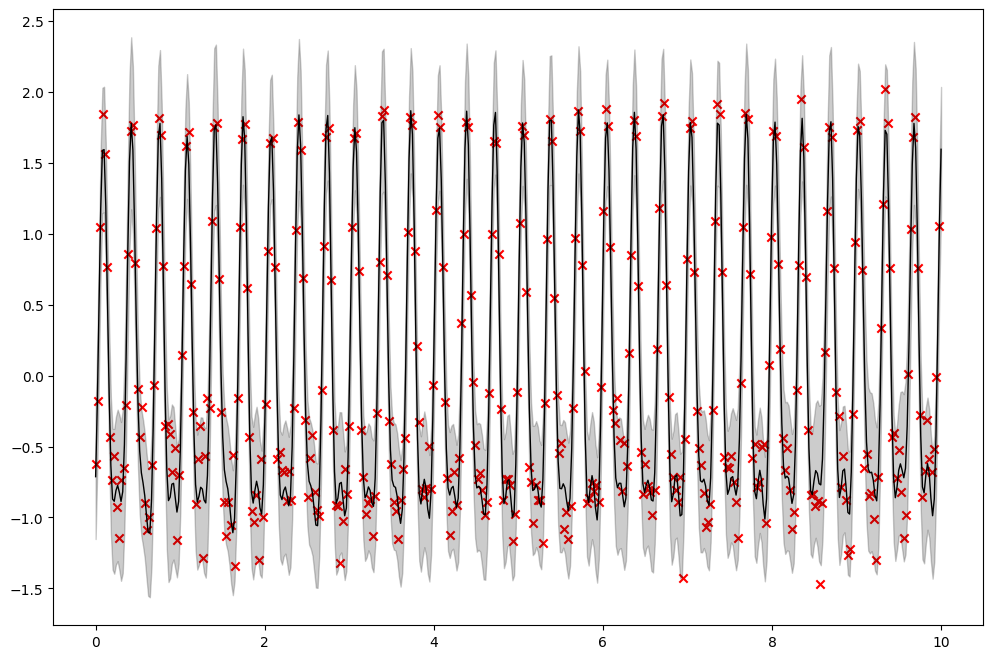

In [15]:
lon_idx4visual, lat_idx4visual = 0, 0
norm_new_tas_data4visual, norm_new_loc_data4visual = pick_new_spatio_temp_data_and_loc(lon_idx4visual, lat_idx4visual, new_lon_torch, new_lat_torch)

## for visualization
pred_dist4visual = my_likelihood(my_model(norm_new_loc_data4visual.reshape(1, -1).repeat(n_data4visual,1), inputs_total4visual.reshape(-1,1)))
pred_mean4visual = pred_dist4visual.loc.detach().data
pred_var4visual = pred_dist4visual.variance.detach().data

plt.figure(figsize=(12, 8))
plt.scatter(data_inputs, norm_new_tas_data4visual, c='r', marker='x', label='Data Points')
plt.plot(inputs_total4visual, pred_mean4visual, 'k', lw=1, zorder=9)
plt.fill_between(inputs_total4visual, pred_mean4visual - 1.96 * pred_var4visual.sqrt(), pred_mean4visual + 1.96 * pred_var4visual.sqrt(), alpha=0.2, color='k')

In [16]:
# NOTE: only predict on single selected output (unseen)
'''
## all data points
pred_dist = my_likelihood(my_model(norm_new_loc_data.reshape(1, -1).repeat(config['n_input'],1), data_inputs.reshape(-1,1)))
pred_mean = pred_dist.loc.detach().data
pred_var = pred_dist.variance.detach().data

## for visualization
pred_dist4visual = my_likelihood(my_model(norm_new_loc_data.reshape(1, -1).repeat(n_data4visual,1), inputs_total4visual.reshape(-1,1)))
pred_mean4visual = pred_dist4visual.loc.detach().data
pred_var4visual = pred_dist4visual.variance.detach().data

# Evaluate on unseen output !

test_rmse_on_new_output = (pred_mean[config['n_input_train']:] - norm_new_tas_data[config['n_input_train']:]).square().mean().sqrt()
test_nll_on_new_output = neg_log_likelihood(Target=norm_new_tas_data[config['n_input_train']:],
                                            GaussianMean=pred_mean[config['n_input_train']:], 
                                            GaussianVar=pred_var[config['n_input_train']:])

print('test rmse on new output', test_rmse_on_new_output)
print('test nll on new output', test_nll_on_new_output)
'''

"\n## all data points\npred_dist = my_likelihood(my_model(norm_new_loc_data.reshape(1, -1).repeat(config['n_input'],1), data_inputs.reshape(-1,1)))\npred_mean = pred_dist.loc.detach().data\npred_var = pred_dist.variance.detach().data\n\n## for visualization\npred_dist4visual = my_likelihood(my_model(norm_new_loc_data.reshape(1, -1).repeat(n_data4visual,1), inputs_total4visual.reshape(-1,1)))\npred_mean4visual = pred_dist4visual.loc.detach().data\npred_var4visual = pred_dist4visual.variance.detach().data\n\n# Evaluate on unseen output !\n\ntest_rmse_on_new_output = (pred_mean[config['n_input_train']:] - norm_new_tas_data[config['n_input_train']:]).square().mean().sqrt()\ntest_nll_on_new_output = neg_log_likelihood(Target=norm_new_tas_data[config['n_input_train']:],\n                                            GaussianMean=pred_mean[config['n_input_train']:], \n                                            GaussianVar=pred_var[config['n_input_train']:])\n\nprint('test rmse on new output', 